## Hyperparameter Tuning

Unlike algorithms like Random Forest or SVM, PCA has very few hyperparameters, but the main ones are:

### **a) Number of components (`n_components`)**

* **Definition:** The number of principal components to keep (k).
* **Effect:**

  * Too small → lose too much information (high reconstruction error).
  * Too large → include noise, less dimensionality reduction benefit.

### **b) Whiten**

* **Definition:** Whether to scale the principal components to unit variance.
* **Effect:**

  * `whiten=True` → components are decorrelated and scaled.
  * Useful for feeding into algorithms sensitive to scale (like k-NN, SVM).

### **c) Solver**

* **Options:** `auto`, `full`, `arpack`, `randomized`
* **Effect:** Determines algorithm to compute SVD (can affect speed for large datasets).

---

## 2. **Hyperparameter Tuning Goal**

For PCA, tuning usually means **selecting `n_components`** to balance:

1. **Variance explained:** Keep enough components to capture most variance.
2. **Dimensionality reduction:** Reduce features as much as possible.

---

## 3. **Techniques for Tuning `n_components`**

### **a) Variance Explained Threshold**

* Plot **cumulative explained variance ratio** and pick components that capture e.g., 90–95% of variance.
* Formula:

$$
\text{Explained Variance Ratio} = \frac{\lambda_i}{\sum_{j=1}^{d} \lambda_j}
$$

Where $\lambda_i$ is the i-th eigenvalue.

**Rule of Thumb:** Keep the smallest number of components that explains ≥90–95% of variance.

---

### **b) Cross-Validation (with downstream task)**

If PCA is used **before a supervised learning model**:

1. Try different `n_components`.
2. Train your model (e.g., logistic regression) on the reduced data.
3. Evaluate performance (accuracy, F1-score, etc.).
4. Pick `n_components` giving best validation performance.

This is more robust because variance alone doesn’t guarantee optimal performance for predictive tasks.

---

### **c) Scree Plot**

* Plot eigenvalues (variance per component) vs component index.
* Look for **“elbow”**, where adding more components gives diminishing returns.

---

### **4. Quick Summary Table**

| Hyperparameter | Tuning Strategy                                          | Notes                                   |
| -------------- | -------------------------------------------------------- | --------------------------------------- |
| `n_components` | Variance threshold, CV with downstream model, scree plot | Most important                          |
| `whiten`       | Try True/False                                           | Useful if model sensitive to scale      |
| `solver`       | Depends on data size                                     | Large datasets → `randomized` for speed |

---

**Intuition**

* PCA is **unsupervised**, so tuning is mostly about **information retention**.
* If using PCA as preprocessing, always validate via **model performance** after dimensionality reduction.

### Handle Overfitting/Underfitting

PCA is an **unsupervised dimensionality reduction technique**, so overfitting/underfitting is less direct than in supervised learning. However, it still matters **when PCA is used as preprocessing for a model**:

* **Overfitting:**

  * Happens if you retain **too many principal components**, including noise.
  * The downstream model learns noise instead of signal.
* **Underfitting:**

  * Happens if you retain **too few principal components**, losing important information.
  * The downstream model cannot capture the true patterns in data.

---

### **2. How to Handle Overfitting in PCA**

#### **a) Reduce number of components**

* Keep only the components that capture the majority of variance (90–95%).
* Discard minor components which may contain noise.

#### **b) Use Cross-Validation**

* Evaluate model performance with different `n_components`.
* Choose the number of components that optimizes validation performance.

#### **c) Regularization in downstream models**

* Even with PCA, the model itself can overfit. Apply regularization (L1/L2) after dimensionality reduction.

---

### **3. How to Handle Underfitting in PCA**

#### **a) Increase number of components**

* If too little variance is retained, include more principal components.

#### **b) Feature engineering**

* PCA reduces dimensions but cannot create new signal. Ensure important features are not discarded before PCA.

#### **c) Use non-linear dimensionality reduction**

* Standard PCA is linear. If patterns are non-linear, try Kernel PCA or t-SNE for better representation.

---

### **4. Practical Workflow to Avoid Overfitting/Underfitting**

1. **Standardize data** → PCA is sensitive to scale.
2. **Compute explained variance ratio** → Decide initial `n_components`.
3. **Cross-validate downstream model** with different `n_components`.
4. **Monitor performance** → Look for improvement plateau to avoid overfitting.
5. **Adjust components** → Increase if underfitting, decrease if overfitting.

---

**Intuition**

* Think of PCA as a **filter**:

  * Keep enough components to preserve signal → avoid underfitting.
  * Discard components that capture noise → avoid overfitting.

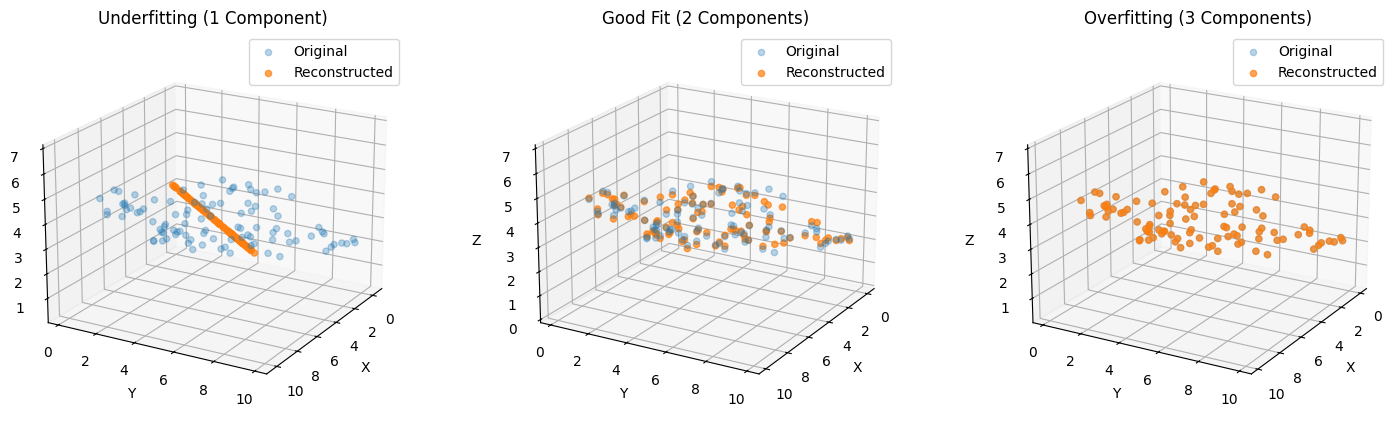

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Generate synthetic 3D data
np.random.seed(42)
n_samples = 100
X = np.random.rand(n_samples, 2) * 10
Z_noise = np.random.randn(n_samples) * 0.2  # small noise in 3rd dimension
X = np.column_stack((X, 0.5*X[:,0] + 0.2*X[:,1] + Z_noise))

# Apply PCA with different components
components = [1, 2, 3]
reconstructions = []

for k in components:
    pca = PCA(n_components=k)
    X_reduced = pca.fit_transform(X)
    X_reconstructed = pca.inverse_transform(X_reduced)
    reconstructions.append(X_reconstructed)

# Plot original and reconstructed data
fig = plt.figure(figsize=(18, 5))

titles = ["Underfitting (1 Component)", "Good Fit (2 Components)", "Overfitting (3 Components)"]

for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.3, label='Original')
    ax.scatter(reconstructions[i][:, 0], reconstructions[i][:, 1], reconstructions[i][:, 2],
               alpha=0.7, label='Reconstructed')
    ax.set_title(titles[i])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(20, 30)
    ax.legend()

plt.show()

### **What You’ll See in the 3D Plot**

1. **Underfitting (1 component):**

   * Reconstruction flattens data along a single direction.
   * Large reconstruction error, main structure lost.

2. **Good Fit (2 components):**

   * Captures main plane of data.
   * Reconstruction is accurate, minimal loss.

3. **Overfitting (3 components):**

   * Includes tiny noisy 3rd dimension.
   * Slight improvement in reconstruction but may introduce noise for downstream models.

